# 다음 안내를 반드시 따라주시기 바랍니다.
- 메일로 할당받은 GPU 번호를 반드시 입력바랍니다.
- 새로 만드시는 jupyter file에도 아래의 셀(GPU지정 코드, 메모리 제한 코드)를 복사하여 실행 바랍니다.

In [ ]:
# gpu 지정

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3' #tensorflow log level 제한
os.environ['CUDA_VISIBLE_DEVICES']="메일로 할당받은 GPU 번호" # ← 여기에 메일로 할당받은 gpu 번호를 입력바랍니다
## 입력예시)   os.environ['CUDA_VISIBLE_DEVICES']="100"


# gpu 메모리 제한
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try: tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16225)])
    except RuntimeError as e: print(e)


In [ ]:
## 1. Data input

import pandas as pd
from pandas import DataFrame
import numpy as np
import glob
import pickle
from PIL import Image
from time import time

# Table
datathon_raw=pd.read_csv('dataset/datathon_train/datathon_train.csv', sep=',', encoding='utf-8-sig')



In [ ]:
## 2. Table 전처리

# OUTCOME이 .2인 값 인덱스 확인 및 제거
outcome_2=datathon_raw[datathon_raw['OUTCOME']==2].index
datathon=datathon_raw.drop(outcome_2, inplace=False)

# 컬럼 이름 및 값 수정
datathon=datathon.rename(columns={'초기산소\n요구도':'init_oxy',
                        'ESRD\n(HD여부)':'ESRD',
                        '고형암(C':'solidcancer',
                        '혈액암(D)':'bloodcancer',
                        '천식':'asthma',
                        'eGFR-Schwartz(소아)':'eGFR-Schwartz'})

datathon=datathon.replace({'20대' : '20_age', '30대' : '30_age',
                           '40대' : '40_age', '50대' : '50_age',
                           '60대' : '60_age', '70대' : '70_age',
                           '80대' : '80_age', '90세 이상' : '90_age'})

# One-Hot encoding
sex_feature=pd.get_dummies(datathon['sex'])
datathon=pd.concat([datathon,sex_feature],axis=1)

age_feature=pd.get_dummies(datathon['age'])
datathon=pd.concat([datathon,age_feature],axis=1)

# 제외할 column
datathon=datathon.drop(['sex','age','Myelocyte','Metamyelo','Band.neut.',
                        'Blast','Promyelo','Imm.cell','Imm.lympho','Imm.mono',
                        'AtypicalLc','Plas.cell','Other','Normoblast','LUC'],axis=1)


In [ ]:
## 3. Data split

from sklearn.model_selection import train_test_split

x = datathon[datathon.columns.difference(['OUTCOME'])]
y = datathon[['id','OUTCOME']]


x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=test_size, random_state=123, stratify=y.loc[:,"OUTCOME"])
img_train=split_image(y_train)
img_test=split_image(y_test)

#null값 채우기 : train값의 평균
x_train=x_train.fillna(x_train.mean())
x_test=x_test.fillna(x_train.mean())

In [ ]:
# model summary
model.summary()

In [ ]:
## 4. Final classifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn import metrics

def pred_eval(y_test, y_pred, model):
    print("Model : ", model)
    print('정확도(Accuracy)  : ' , round(accuracy_score(y_test, y_pred), 5))
    print('정밀도(Precision) : ' , round(precision_score(y_test, y_pred), 5))
    print('재현율(Recall)    : ' , round(recall_score(y_test, y_pred), 5))
    print('F1 score         : ' , round(f1_score(y_test, y_pred), 5))
    print('AUC              : ' , round(roc_auc_score(y_test, y_pred), 5),"\n")


def rf_default(x_train, y_train, x_test, y_test):
    start=time()
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    feature_importance = clf.feature_importances_
    pred_eval(y_test, y_pred, "Random Forest, default")
    print("model fit(Random Forest, default) : {} 분\n".format(round((time()-start)/60, 2)))
    return y_pred, feature_importance

def xg_default(x_train, y_train, x_test, y_test):
    start=time()
    clf = XGBClassifier()
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    feature_importance = clf.feature_importances_
    pred_eval(y_test, y_pred, "XGBoost, default")
    print("model fit(XGBoost, default) : {} 분\n".format(round((time()-start)/60, 2)))
    return y_pred, feature_importance


In [ ]:
## 5. Result

import seaborn as sns
import matplotlib.pyplot as plt

def feature_impo(feature_importance, X_train, model):
    feature_imp=np.array(feature_importance)
    feature_name=np.array(X_train.columns)
    data={"feature_name": feature_name, "feature_importance":feature_imp}
    data=pd.DataFrame(data)
    data.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(10,20))
    sns.barplot(x=data['feature_importance'], y=data["feature_name"])
    plt.title(model+" feature importance")
    plt.show()
    return 

def feature_impo_df(feature_importance, X_train):
    feature_importance = pd.Series(feature_importance, index=X_train.columns)
    feature_top = feature_importance.sort_values(ascending=False)[:len(X_train)]
    feature = pd.DataFrame(feature_top.reset_index())
    feature.columns = ['feature', 'importance']
    return feature

#confusion matrix
def confu(y_test, y_pred, model):
    result = pd.concat([y_test.loc[:,['OUTCOME']].reset_index(drop=True),pd.DataFrame(y_pred,columns=['예측값'])],axis=1)
    cm=pd.DataFrame(confusion_matrix(result['OUTCOME'],result['예측값']))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(model+" Confusion Metrix")


In [ ]:
## 결과 출력
## model result
X_train=af_img_train_rmid
Y_train=y_train.loc[:,'OUTCOME']
X_test=af_img_test_rmid
Y_test=y_test.loc[:, 'OUTCOME']

y_pred_rf, feature_importance_rf=rf_default(X_train, Y_train, X_test, Y_test)
y_pred_xg, feature_importance_xg=xg_default(X_train, Y_train, X_test, Y_test)


Model :  Random Forest, default
정확도(Accuracy)  :  0.85714
정밀도(Precision) :  0.76923
재현율(Recall)    :  0.60606
F1 score         :  0.67797
AUC              :  0.77303 

model fit(Random Forest, default) : 0.0 분

Model :  XGBoost, default
정확도(Accuracy)  :  0.85714
정밀도(Precision) :  0.73333
재현율(Recall)    :  0.66667
F1 score         :  0.69841
AUC              :  0.79333 

model fit(XGBoost, default) : 0.01 분



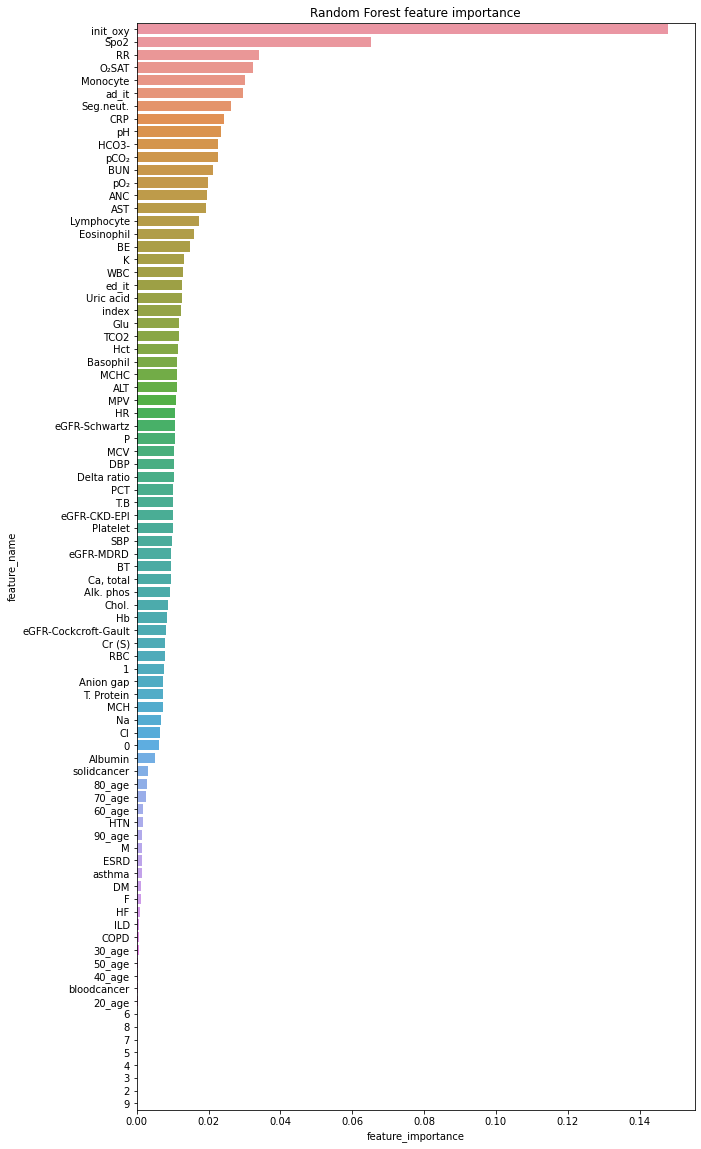

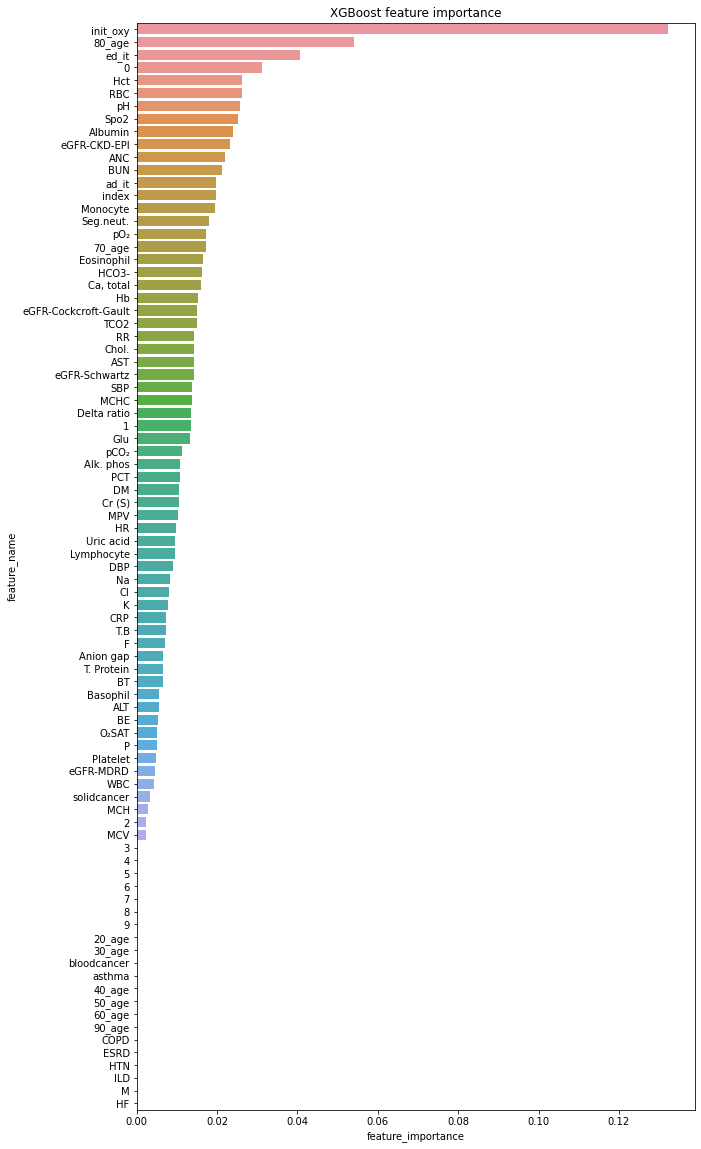

In [ ]:
# feature importance
rfimpo=feature_impo(feature_importance_rf, X_test, "Random Forest")
xgimpo=feature_impo(feature_importance_xg, X_test, "XGBoost")

In [ ]:
# feature importance_table
feature_impo_df(feature_importance_rf, X_test)

,feature,importance
0,init_oxy,0.147947
1,Spo2,0.065265
2,RR,0.033942
3,O₂SAT,0.032282
4,Monocyte,0.030143
...,...,...
80,5,0.000000
81,4,0.000000
82,3,0.000000
83,2,0.000000


In [ ]:
# feature importance_table
feature_impo_df(feature_importance_xg, X_test)

,feature,importance
0,init_oxy,0.132238
1,80_age,0.054088
2,ed_it,0.040704
3,0,0.031111
4,Hct,0.026264
...,...,...
80,ESRD,0.000000
81,HTN,0.000000
82,ILD,0.000000
83,M,0.000000


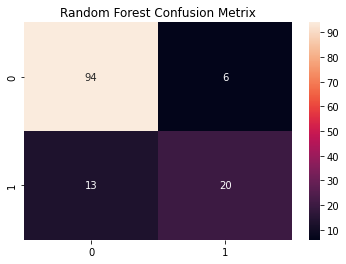

In [ ]:
# confusion matrix
confu(DataFrame(Y_test), y_pred_rf, "Random Forest")

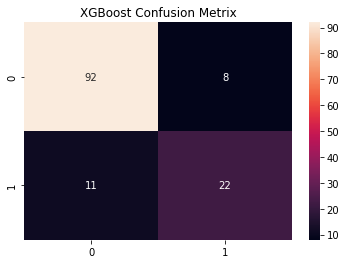

In [ ]:
# confusion matrix
confu(DataFrame(Y_test), y_pred_xg, "XGBoost")